In [12]:
import cv2
import numpy as np
import os
from tensorflow.keras.applications import EfficientNetV2B0,MobileNetV2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, TimeDistributed,LSTM, Dropout,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


<h1> Model 0

<h3>No transfer learning or pre trained weights, pretty slow and exhausting when it comes down to computing time, better switch to some other models

In [5]:
def load_video_data(data_dir):
    video_data = []
    labels = []

    # Assuming your data is organized in subdirectories for each class (explicit and non-explicit)
    classes = os.listdir(data_dir)

    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        
        for video_file in os.listdir(class_path):
            video_path = os.path.join(class_path, video_file)
            
            frames = extract_frames(video_path)
            video_data.append(frames)

            # Assign label based on class_name (e.g., 'explicit' or 'non_explicit')
            label = 1 if class_name.lower() == 'explicit' else 0
            labels.append(label)
            

    return video_data, labels


def extract_frames(file_path, num_frames=30):
    # Check if it's an image or video
    _, file_extension = os.path.splitext(file_path)

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        frame = cv2.resize(frame, (224, 224))
        frames = [preprocess_frame(frame)]
        while len(frames) < num_frames:
            frames.append(frames[-1])
        

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)
        frames = []

        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, (224, 224))
            preprocessed_frame = preprocess_frame(frame)
            frames.append(preprocessed_frame)
    

        cap.release()
    return frames


def preprocess_frame(frame):
    preprocessed_frame = preprocess_input(img_to_array(frame))
    skin_mask = extract_skin_mask(frame)
    blood_mask = extract_blood_mask(frame)
    preprocessed_frame = np.concatenate([preprocessed_frame, skin_mask[..., None], blood_mask[..., None]], axis=-1)
    return preprocessed_frame



def extract_skin_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype="uint8")
    upper_skin = np.array([20, 255, 255], dtype="uint8")

    # Create a binary mask for the skin region
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Apply morphological operations to smooth the mask
    skin_mask = cv2.erode(skin_mask, None, iterations=2)
    skin_mask = cv2.dilate(skin_mask, None, iterations=2)

    return skin_mask



def extract_blood_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for blood color in HSV
    lower_blood = np.array([0, 100, 100], dtype="uint8")
    upper_blood = np.array([10, 255, 255], dtype="uint8")

    # Create a binary mask for the blood region
    blood_mask = cv2.inRange(hsv, lower_blood, upper_blood)

    # Apply morphological operations to smooth the mask
    blood_mask = cv2.erode(blood_mask, None, iterations=2)
    blood_mask = cv2.dilate(blood_mask, None, iterations=2)

    return blood_mask





def build_model(input_shape=(30, 224, 224, 5)):
    # Define the input layer with 5 channels
    input_layer = Input(shape=input_shape)

    # Convolutional layers
    conv1 = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(input_layer)
    maxpool1 = TimeDistributed(MaxPooling2D((2, 2)))(conv1)
    conv2 = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(maxpool1)
    maxpool2 = TimeDistributed(MaxPooling2D((2, 2)))(conv2)

    # Flatten before feeding to LSTM
    flatten = TimeDistributed(Flatten())(maxpool2)

    # LSTM layers
    lstm1 = LSTM(128, return_sequences=True)(flatten)
    lstm2 = LSTM(64)(lstm1)

    # Dense layers
    dense1 = Dense(64, activation='relu')(lstm2)
    output_layer = Dense(1, activation='sigmoid')(dense1)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model



# Example usage:
data_dir = 'train'
video_data, labels = load_video_data(data_dir)
batch_size = 32
input_shape = (30, 224, 224, 5)
model = build_model(input_shape)
model.summary()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(video_data, labels, test_size=0.2, random_state=42)

# Train the model
model.fit(np.array(X_train), np.array(y_train), epochs=10, validation_data=(np.array(X_val), np.array(y_val)))

# Save the model
model.save('explicit_content_classifier_video.h5')


: 

<h1> Model 1

<h3>Same model, but treated as individual frames. Retains no temporal information

In [ ]:


def load_video_data(data_dir, batch_size=64):
    video_data = []
    labels = []

    classes = os.listdir(data_dir)

    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)

        for video_file in os.listdir(class_path):
            video_path = os.path.join(class_path, video_file)

            frames = extract_frames(video_path)

            label = 1 if class_name.lower() == 'explicit' else 0

            for frame in frames:
                video_data.append(frame)
                labels.append(label)

                if len(video_data) == batch_size:
                    yield np.array(video_data), np.array(labels)
                    video_data, labels = [], []

    if video_data:
        yield np.array(video_data), np.array(labels)

def extract_frames(file_path):
    _, file_extension = os.path.splitext(file_path)

    frames = []

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        frame = cv2.resize(frame, (224, 224))
        preprocessed_frame = preprocess_frame(frame)
        frames.append(preprocessed_frame)

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, (224, 224))
            preprocessed_frame = preprocess_frame(frame)
            frames.append(preprocessed_frame)

        cap.release()
    return frames

def preprocess_frame(frame):
    preprocessed_frame = preprocess_input(img_to_array(frame))
    return preprocessed_frame

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

train_data_dir = 'train'
val_data_dir = 'val'

train_data_gen = load_video_data(train_data_dir)
val_data_gen = load_video_data(val_data_dir)

for X_train, y_train in train_data_gen:
    X_val, y_val = next(val_data_gen)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[early_stopping], verbose=1)

model.summary()

model.save('explicit_content_classifier_video1.h5')

Epoch 1/10
2/2 [==============================] - 7s 1s/step - loss: 0.1372 - accuracy: 0.9531 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 0s 133ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
2/2 [==============================] - 0s 133ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 0s 131ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 128ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 130ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1/10
2/2 [==============================] - 0s 181ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.000

StopIteration: 

In [ ]:
model.summary()
model.save('explicit_content_classifier_video1.h5')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4014144   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,272,193
Trainable params: 4,014,209
Non-trainable params: 2,257,984
_________________________________________________________________


<h3>Accuracy

In [ ]:
model = load_model('explicit_content_classifier_video1.h5')


In [ ]:
test_data_dir = 'test'
test_data_gen = load_video_data(test_data_dir)

# Initialize counters
total_samples = 0
correct_predictions = 0

# Evaluate the model on the test data
for X_test, y_test in test_data_gen:
    # Predict the labels of the test data
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)

    # Update counters
    total_samples += y_test.shape[0]
    correct_predictions += np.sum(y_pred == y_test)

# Calculate overall accuracy
overall_accuracy = correct_predictions / total_samples
print('Overall accuracy:', overall_accuracy)

Overall accuracy: 49.396484375


<h3>Real-time testing

In [ ]:
import cv2

def predict_video(model, video_path):
    cap = cv2.VideoCapture(video_path)
    predictions = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (224, 224))
        preprocessed_frame = preprocess_frame(frame)

        # Add an extra dimension for the batch size
        preprocessed_frame = np.expand_dims(preprocessed_frame, axis=0)

        # Predict the label of the frame
        prediction = model.predict(preprocessed_frame)
        predictions.append(prediction)

        # Print the prediction for the current frame
        # print('Prediction for current frame:', prediction)

        # Display the frame and its predicted label
        label = 'Explicit' if prediction > 0.5 else 'Not explicit'
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow('Video', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Average the predictions to get the overall prediction for the video
    avg_prediction = np.mean(predictions)
    return avg_prediction

video_path = 'test/explicit/Etrain13.mp4'
avg_prediction = predict_video(model, video_path)

if avg_prediction > 0.5:
    print('The video is explicit.')
else:
    print('The video is not explicit.')

In [ ]:
def prepare_test_data(video_path, max_length=100):
    frames = extract_frames(video_path)
    frames_padded = pad_sequences([frames], maxlen=max_length, dtype='float32', padding='post')
    return frames_padded[0]
test_video_path = 'train/non-explicit/NEtrain1.mp4'  # Replace with the path to your test video

test_data = prepare_test_data(test_video_path)
test_data_padded = pad_sequences([test_data], maxlen=50, dtype='float32', padding='post')

predictions = model.predict(test_data_padded)


In [ ]:
print(predictions)

[[0.00249955]]


<h1> Model 2

<h3>Using EfficientNetV2B0 as a pre-trained weight and transfer learning, good computing time <br>
Only tried for obscene videos

In [21]:
def extract_frames(file_path, num_frames=30):
    # Check if it's an image or video
    _, file_extension = os.path.splitext(file_path)

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        frame = cv2.resize(frame, (224, 224))
        frames = [preprocess_frame(frame)]
        while len(frames) < num_frames:
            frames.append(frames[-1])

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)
        frames = []

        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, (224, 224))
            preprocessed_frame = preprocess_frame(frame)
            frames.append(preprocessed_frame)

        cap.release()
    return frames

def preprocess_frame(frame):
    preprocessed_frame = preprocess_input(img_to_array(frame))
    skin_mask = extract_skin_mask(frame)
    blood_mask = extract_blood_mask(frame)
    preprocessed_frame = np.concatenate([preprocessed_frame], axis=-1)
    return preprocessed_frame

def extract_skin_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype="uint8")
    upper_skin = np.array([20, 255, 255], dtype="uint8")

    # Create a binary mask for the skin region
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Apply morphological operations to smooth the mask
    skin_mask = cv2.erode(skin_mask, None, iterations=2)
    skin_mask = cv2.dilate(skin_mask, None, iterations=2)

    return skin_mask

def extract_blood_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for blood color in HSV
    lower_blood = np.array([0, 100, 100], dtype="uint8")
    upper_blood = np.array([10, 255, 255], dtype="uint8")

    # Create a binary mask for the blood region
    blood_mask = cv2.inRange(hsv, lower_blood, upper_blood)

    # Apply morphological operations to smooth the mask
    blood_mask = cv2.erode(blood_mask, None, iterations=2)
    blood_mask = cv2.dilate(blood_mask, None, iterations=2)

    return blood_mask

In [4]:


def load_video_data(data_dir):
    video_data = []
    labels = []

    # Assuming your data is organized in subdirectories for each class (explicit and non-explicit)
    classes = os.listdir(data_dir)

    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)

        for video_file in os.listdir(class_path):
            video_path = os.path.join(class_path, video_file)

            frames = extract_frames(video_path)
            video_data.append(frames)

            # Assign label based on class_name (e.g., 'explicit' or 'non_explicit')
            label = 1 if class_name.lower() == 'explicit' else 0
            labels.append(label)

    return video_data, labels


# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        augmented_frame = datagen.random_transform(frame)
        augmented_frames.append(augmented_frame)
    return augmented_frames

# Build Model with Transfer Learning
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

model = Sequential([
    TimeDistributed(base_model),
    TimeDistributed(Flatten()),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Example usage:
data_dir = 'train'
video_data, labels = load_video_data(data_dir)
batch_size = 32
input_shape = (30, 224, 224, 5)  # Updated input shape
# model.summary()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(video_data, labels, test_size=0.2, random_state=42)

# Train the model with data augmentation
for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    print(len(labels))
    i= 0
    for frames, label in zip(video_data, labels):
        print(i)
        augmented_frames = augment_frames(frames)
        
        # Assuming augment_frames returns a list of frames for a single video
        augmented_frames = np.array(augmented_frames)
        augmented_frames = np.expand_dims(augmented_frames, axis=0)  # Add batch dimension

        # Assuming label is a single value
        label = np.array([label])
        i+=1
        model.fit(augmented_frames, label, epochs=1, verbose=0)

# Evaluate on the validation set
model.evaluate(np.array(X_val), np.array(y_val))

model.summary()
# Save the model
model.save('explicit_content_classifier_video.h5')

Epoch 1/10
62
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
Epoch 2/10
62
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
Epoch 3/10
62
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
Epoch 4/10
62
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
Epoch 5/10
62
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
Epoch 6/10
62
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1

<h3> Accuracy

In [5]:
model = load_model('explicit_content_classifier_video.h5')

In [20]:
# Load test data
test_data_dir = 'test'
X_test, y_test = load_video_data(test_data_dir)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape data
# X_test = np.reshape(X_test, (len(X_test), 30, 224, 224, 5))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

1/1 [==============================] - 492s 492s/step - loss: 1.4879 - accuracy: 0.7000
Test loss: 1.4879276752471924
Test accuracy: 0.699999988079071


<h3>Visualization

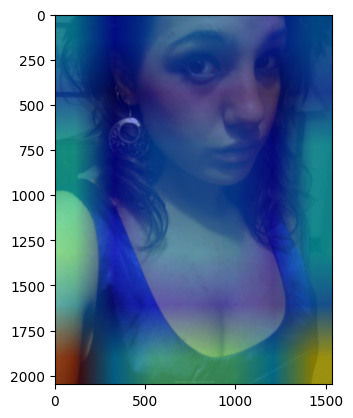

In [ ]:
def extract_frames(file_path, num_frames=30):
    # Check if it's an image or video
    _, file_extension = os.path.splitext(file_path)

    original_frames = []
    preprocessed_frames = []

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        original_frames.append(frame)
        frame = cv2.resize(frame, (224, 224))
        preprocessed_frames.append(preprocess_frame(frame))
        while len(preprocessed_frames) < num_frames:
            preprocessed_frames.append(preprocessed_frames[-1])
            original_frames.append(original_frames[-1])

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)

        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            original_frames.append(frame)
            frame = cv2.resize(frame, (224, 224))
            preprocessed_frame = preprocess_frame(frame)
            preprocessed_frames.append(preprocessed_frame)

        cap.release()
    return original_frames, preprocessed_frames

# Extract frames from the video
# Extract frames from the video
original_frames, preprocessed_frames = extract_frames('test/val1 (997).jpg')

# Convert the preprocessed frames to an array
frames = np.array(preprocessed_frames)
frames = frames.reshape((-1, 30, 224, 224, 3))

# Select one original frame and one preprocessed frame
selected_original_frame = original_frames[0]
selected_frame = frames[0, 0, :, :, :]

# Use the model to predict the output of the video
output = model.predict(frames)

# Create a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(frames)

# Visualization of the first layer activation corresponding to the selected frame
first_layer_activation = activations[0][0, 0, :, :, 0]

# Normalize the activation
normalized_activation = cv2.normalize(first_layer_activation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Apply the colormap
colored_activation = cv2.applyColorMap(normalized_activation, cv2.COLORMAP_JET)

# Resize the activation to match the size of the original frame
resized_activation = cv2.resize(colored_activation, (selected_original_frame.shape[1], selected_original_frame.shape[0]))

# Overlay the activation on the original frame
overlay = cv2.addWeighted(cv2.cvtColor(selected_original_frame, cv2.COLOR_BGR2RGB), 0.5, resized_activation, 0.5, 0)

# Display the overlay
plt.imshow(overlay)
plt.show()

<h3>Real-time Testing

In [ ]:
def test_model_on_video(model, video_path, num_frames=30):
    # Extract frames from the video
    test_frames = extract_frames(video_path, num_frames)

    # Convert the list of frames to a NumPy array
    test_data_array = np.array(test_frames)
    test_data_array = np.expand_dims(test_data_array, axis=0)

    # Make predictions using the loaded model
    predictions = model.predict(test_data_array)
    print(predictions)
    # Assuming binary classification (0 or 1)
    # Convert predictions to binary labels
    binary_predictions = (predictions > 0.5).astype(int)

    return binary_predictions

# Assuming you have a test video file path named test_video_path
test_predictions = test_model_on_video(loaded_model, 'test/Vijay smoking scene.mp4')

# Display or use the predictions as needed
print(test_predictions)

ValueError: in user code:

    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 50, 224, 224, 3), found shape=(None, 330, 224, 224, 3)


<h1>Model 3

<h3>No augmentation, train in batches with a better number of frames, early stopping when there's no improvement

In [ ]:
def extract_frames(file_path, num_frames=60):
    # Check if it's an image or video
    _, file_extension = os.path.splitext(file_path)

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        frame = cv2.resize(frame, (224, 224))
        preprocessed_frame = preprocess_frame(frame)
        frames = [preprocessed_frame] * num_frames  # Repeat the frame to get num_frames

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = total_frames // num_frames if total_frames > num_frames else 1
        frames = []

        for i in range(num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)  # Set the position of the video file
            ret, frame = cap.read()
            if not ret:
                frames.append(frames[-1])  # Repeat the last frame if no more frames in the video
            else:
                frame = cv2.resize(frame, (224, 224))
                preprocessed_frame = preprocess_frame(frame)
                frames.append(preprocessed_frame)

        cap.release()
    return frames

def preprocess_frame(frame):
    preprocessed_frame = preprocess_input(img_to_array(frame))
    skin_mask = extract_skin_mask(frame)
    blood_mask = extract_blood_mask(frame)
    preprocessed_frame = np.concatenate([preprocessed_frame], axis=-1)
    return preprocessed_frame

def extract_skin_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype="uint8")
    upper_skin = np.array([20, 255, 255], dtype="uint8")

    # Create a binary mask for the skin region
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Apply morphological operations to smooth the mask
    skin_mask = cv2.erode(skin_mask, None, iterations=2)
    skin_mask = cv2.dilate(skin_mask, None, iterations=2)

    return skin_mask

def extract_blood_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for blood color in HSV
    lower_blood = np.array([0, 100, 100], dtype="uint8")
    upper_blood = np.array([10, 255, 255], dtype="uint8")

    # Create a binary mask for the blood region
    blood_mask = cv2.inRange(hsv, lower_blood, upper_blood)

    # Apply morphological operations to smooth the mask
    blood_mask = cv2.erode(blood_mask, None, iterations=2)
    blood_mask = cv2.dilate(blood_mask, None, iterations=2)

    return blood_mask

def load_video_data(data_dir):
    video_data = []
    labels = []

    # Assuming your data is organized in subdirectories for each class (explicit and non-explicit)
    classes = os.listdir(data_dir)

    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)

        for video_file in os.listdir(class_path):
            video_path = os.path.join(class_path, video_file)

            frames = extract_frames(video_path)
            video_data.append(frames)

            # Assign label based on class_name (e.g., 'explicit' or 'non_explicit')
            label = 1 if class_name.lower() == 'explicit' else 0
            labels.append(label)

    return video_data, labels


In [2]:
# Build Model with Transfer Learning
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

model = Sequential([
    TimeDistributed(base_model),
    TimeDistributed(Flatten()),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])



# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load training data
train_data_dir = 'train'
X_train, y_train = load_video_data(train_data_dir)

# Load validation data
val_data_dir = 'val'
X_val, y_val = load_video_data(val_data_dir)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Reshape data
num_frames = 60
# X_train = np.reshape(X_train, (len(X_train), num_frames, 224, 224, 5))
# X_val = np.reshape(X_val, (len(X_val), num_frames, 224, 224, 5))

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model in batches
model.fit(X_train, y_train, epochs=10, batch_size=4, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

#save model
model.save('explicit_content_classifier_video2.h5')

Epoch 1/10
6/6 [==============================] - 27s 2s/step - loss: 0.5417 - accuracy: 0.7500 - val_loss: 0.3430 - val_accuracy: 0.9091
Epoch 2/10
6/6 [==============================] - 3s 527ms/step - loss: 0.2341 - accuracy: 1.0000 - val_loss: 0.1801 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 3s 525ms/step - loss: 0.1023 - accuracy: 1.0000 - val_loss: 0.1127 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 3s 542ms/step - loss: 0.0453 - accuracy: 1.0000 - val_loss: 0.0852 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 3s 536ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 3s 533ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 3s 532ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 8/10
6/6 [======

<h3> Accuracy

In [6]:
#load model
model = load_model('explicit_content_classifier_video2.h5')

In [3]:
# Load test data
test_data_dir = 'test'
X_test, y_test = load_video_data(test_data_dir)

# Reshape data
# X_test = np.reshape(X_test, (len(X_test), 30, 224, 224, 5))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

1/1 [==============================] - 4s 4s/step - loss: 0.4336 - accuracy: 0.9000
Test loss: 0.43360501527786255
Test accuracy: 0.8999999761581421


In [ ]:

y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.88      0.78      0.82         9

    accuracy                           0.81        16
   macro avg       0.81      0.82      0.81        16
weighted avg       0.82      0.81      0.81        16



In [ ]:
#predict with the model
def predict_video(video_path):
    frames = extract_frames(video_path)
    frames = np.expand_dims(frames, axis=0)
    y_pred = model.predict(frames)[0]
    return y_pred

#predict with the model
y_pred = predict_video('test/non-explicit/val1 (975).jpg')
print(y_pred)

[0.9859542]


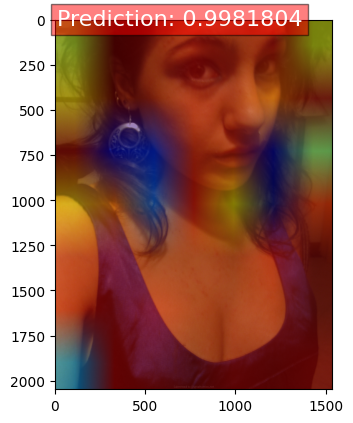

In [16]:
def extract_frames(file_path, num_frames=60):
    # Check if it's an image or video
    _, file_extension = os.path.splitext(file_path)

    original_frames = []
    preprocessed_frames = []

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        original_frames.append(frame)  # Append the original frame
        frame = cv2.resize(frame, (224, 224))
        preprocessed_frame = preprocess_frame(frame)
        preprocessed_frames = [preprocessed_frame] * num_frames  # Repeat the preprocessed frame

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = total_frames // num_frames if total_frames > num_frames else 1

        for i in range(num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)  # Set the position of the video file
            ret, frame = cap.read()
            if not ret:
                preprocessed_frames.append(preprocessed_frames[-1])  # Repeat the last preprocessed frame
                original_frames.append(original_frames[-1])  # Repeat the last original frame
            else:
                original_frames.append(frame)  # Append the original frame
                frame = cv2.resize(frame, (224, 224))
                preprocessed_frame = preprocess_frame(frame)
                preprocessed_frames.append(preprocessed_frame)

        cap.release()
    return original_frames, preprocessed_frames

# Extract frames from the video
# Extract frames from the video
original_frames, preprocessed_frames = extract_frames('test/explicit/val1 (997).jpg')

# Convert the preprocessed frames to an array
frames = np.array(preprocessed_frames)
frames = frames.reshape((-1, 60, 224, 224, 3))

# Select one original frame and one preprocessed frame
selected_original_frame = original_frames[0]
selected_frame = frames[0, 0, :, :, :]

# Use the model to predict the output of the video
output = model.predict(frames)

# Convert the output to a string
output_str = str(output[0][0])

# Create a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(frames)

# Visualization of the first layer activation corresponding to the selected frame
first_layer_activation = activations[0][0, 0, :, :, 0]

# Normalize the activation
normalized_activation = cv2.normalize(first_layer_activation, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Apply the colormap
colored_activation = cv2.applyColorMap(normalized_activation, cv2.COLORMAP_JET)

# Resize the activation to match the size of the original frame
resized_activation = cv2.resize(colored_activation, (selected_original_frame.shape[1], selected_original_frame.shape[0]))

# Overlay the activation on the original frame
overlay = cv2.addWeighted(cv2.cvtColor(selected_original_frame, cv2.COLOR_BGR2RGB), 0.5, resized_activation, 0.5, 0)

# Display the overlay
plt.imshow(overlay)
plt.text(10, 30, 'Prediction: ' + output_str, color='white', fontsize=16, bbox=dict(facecolor='red', alpha=0.5))
plt.show()

<h2> Ignore

Trial for combining both the model in real-time testing

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, TimeDistributed, LSTM, Flatten

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.model_selection import train_test_split

def load_video_data(data_dir):
    video_data = []
    labels = []

    # Assuming your data is organized with subdirectories
    classes = os.listdir(data_dir)

    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)

        if os.path.isdir(class_path):
            subclass_names = os.listdir(class_path)

            for subclass_name in subclass_names:
                subclass_path = os.path.join(class_path, subclass_name)

                for video_file in os.listdir(subclass_path):
                    video_path = os.path.join(subclass_path, video_file)

                    frames = extract_frames(video_path)
                    video_data.append(frames)

                    # Assign label based on class_name and subclass_name
                    label = f"{class_name.lower()}/{subclass_name.lower()}"
                    labels.append(label)

    return video_data, labels

def extract_frames(file_path, num_frames=30):
    # Check if it's an image or video
    _, file_extension = os.path.splitext(file_path)

    if file_extension.lower() in ['.jpg', '.jpeg', '.png']:  # Assuming image format
        frame = cv2.imread(file_path)
        frame = cv2.resize(frame, (224, 224))
        frames = [preprocess_frame(frame)]
        while len(frames) < num_frames:
            frames.append(frames[-1])

    else:  # Assuming video format
        cap = cv2.VideoCapture(file_path)
        frames = []

        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, (224, 224))
            preprocessed_frame = preprocess_frame(frame)
            frames.append(preprocessed_frame)

        cap.release()
    return frames

def preprocess_frame(frame):
    preprocessed_frame = preprocess_input(img_to_array(frame))
    skin_mask = extract_skin_mask(frame)
    blood_mask = extract_blood_mask(frame)
    preprocessed_frame = np.concatenate([preprocessed_frame], axis=-1)
    return preprocessed_frame

def extract_skin_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype="uint8")
    upper_skin = np.array([20, 255, 255], dtype="uint8")

    # Create a binary mask for the skin region
    skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)

    # Apply morphological operations to smooth the mask
    skin_mask = cv2.erode(skin_mask, None, iterations=2)
    skin_mask = cv2.dilate(skin_mask, None, iterations=2)

    return skin_mask

def extract_blood_mask(frame):
    # Convert the frame to the HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for blood color in HSV
    lower_blood = np.array([0, 100, 100], dtype="uint8")
    upper_blood = np.array([10, 255, 255], dtype="uint8")

    # Create a binary mask for the blood region
    blood_mask = cv2.inRange(hsv, lower_blood, upper_blood)

    # Apply morphological operations to smooth the mask
    blood_mask = cv2.erode(blood_mask, None, iterations=2)
    blood_mask = cv2.dilate(blood_mask, None, iterations=2)

    return blood_mask

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        augmented_frame = datagen.random_transform(frame)
        augmented_frames.append(augmented_frame)
    return augmented_frames

# Build Model with Transfer Learning
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

model = Sequential([
    TimeDistributed(base_model),
    TimeDistributed(Flatten()),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification, adjust if needed
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Example usage:
data_dir = 'train'
video_data, labels = load_video_data(data_dir)
batch_size = 32
input_shape = (30, 224, 224, 5)  # Updated input shape

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(video_data, labels, test_size=0.2, random_state=42)

# Train the model with data augmentation
for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    for frames, label in zip(video_data, labels):
        augmented_frames = augment_frames(frames)

        augmented_frames = np.array(augmented_frames)
        augmented_frames = np.expand_dims(augmented_frames, axis=0)

        label = np.array([label])

        model.fit(augmented_frames, label, epochs=1, verbose=0)

# Evaluate on the validation set
model.evaluate(np.array(X_val), np.array(y_val))

model.summary()
# Save the model
model.save('explicit_content_classifier_video1.h5')


Ignore

In [ ]:
print(labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def test_model(model, video_path, num_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []

    # Extract a fixed number of frames from the video
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame to the desired input dimensions
        frame = cv2.resize(frame, (224, 224))

        # Preprocess the frame for the model
        preprocessed_frame = preprocess_input(img_to_array(frame))

        skin_mask = extract_skin_mask(frame)
        blood_mask = extract_blood_mask(frame)

        # Add features to the frame
        preprocessed_frame = np.concatenate([preprocessed_frame, skin_mask[..., None], blood_mask[..., None]], axis=-1)

        frames.append(preprocessed_frame)

    cap.release()

    # Make predictions using the trained model
    predictions = model.predict(np.array([frames]))

    return predictions

# Example usage:
video_path_to_test = 'train/explicit/screenshot-7_fNrXVzXN.mp4'
predictions = test_model(model, video_path_to_test)

# Output the predictions
print("Predictions:", predictions)


ValueError: in user code:

    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "time_distributed" is incompatible with the layer: expected ndim=5, found ndim=2. Full shape received: (None, 0)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 0), dtype=float32)
      • training=False
      • mask=None


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

#tensorflow version
import tensorflow as tf
print(tf.__version__)

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.8.0
